# Utils

In [1]:
# Funções Padrões
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score, accuracy_score, precision_score, recall_score, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from warnings import filterwarnings
filterwarnings(action='ignore')
# Funções Auxiliares
from model_metrics_functions import calculate_metrics, plot_metrics

# Carregamento e Split

* Carregando o set de treino após feature engineering

In [2]:
train_data = pd.read_parquet('BASES_TREINO_TESTE/APPLICATION_TRAIN_FINAL')
train_data.shape

(215257, 220)

* Realizando o Split

In [3]:
X = train_data.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 1)

# Dataprep

* Separando as variáveis numéricas e categóricas

In [4]:
# Separando as variáveis numéricas e categóricas (importante manter o dataframe por causa dos indexes)
num_vars = X.select_dtypes(exclude='object')
cat_vars = X.select_dtypes(include='object')

* Criando as etapas de tratamento e encoding dos dados

In [5]:
# Criando a Pipeline - Variáveis Numéricos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy= 'median')),
    ('scaler', StandardScaler())
])

# Criando a Pipeline - Variáveis Categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('encoder', TargetEncoder())
])

# Criando o Preprocessador
preprocessor = ColumnTransformer([
    ('num_vars', num_pipeline, num_vars.columns),
    ('cat_vars', cat_pipeline, cat_vars.columns)
])

preprocessor = Pipeline(steps= [('preprocessor', preprocessor)])

* Aplicando as modificações

In [6]:
# Set de Treino
X_train_dataprep = pd.DataFrame(
    data = preprocessor.fit_transform(X_train, y_train),
    columns = X_train.columns.tolist()
)

# Set de Teste
X_test_dataprep = pd.DataFrame(
    data = preprocessor.transform(X_test),
    columns = X_test.columns.tolist()
)

# Modelagem

* Teste de modelos pós dataprep

In [7]:
models = [
    lgb.LGBMClassifier(random_state=1, n_jobs=-1),
    XGBClassifier(random_state= 1),
    GradientBoostingClassifier(random_state=1)
]

for model in models:
    # Treino do modelo
    model.fit(X_train_dataprep,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(str(model)[:str(model).find("(")],model, X_train_dataprep, y_train, X_test_dataprep, y_test)
    display(metricas)

[LightGBM] [Info] Number of positive: 12278, number of negative: 138401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34217
[LightGBM] [Info] Number of data points in the train set: 150679, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081484 -> initscore=-2.422346
[LightGBM] [Info] Start training from score -2.422346


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.921110,0.852252,0.038524,0.838371,0.676742,0.519317
1,LGBMClassifier,Teste,0.920623,0.525000,0.016362,0.759682,0.519365,0.387635


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.930388,0.938695,0.155889,0.904942,0.809884,0.642378
1,XGBClassifier,Teste,0.919431,0.426439,0.038956,0.746922,0.493844,0.367257


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.919544,0.699229,0.022153,0.771690,0.543380,0.404707
1,GradientBoostingClassifier,Teste,0.920871,0.586957,0.015777,0.756566,0.513133,0.385615


* Tunning de Hiperparametros - LGBM (Usando Optuna)

In [8]:
EARLY_STOPPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = EARLY_STOPPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    return

def objective(trial):
    # Var. de controle da métrica
    avg_roc = 0

    # Criando os parametros a serem testados
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 20.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 20.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 1000),
        "max_bin": trial.suggest_int("max_bin", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0)
    }

    # Fazendo os Splits (Cross Validation)
    cv = StratifiedKFold(n_splits= 5, random_state= 1, shuffle= True)

    for train_idx, validation_idx in cv.split(X_train, y_train):
        # Instancia o Modelo
        model = lgb.LGBMClassifier(**params, random_state= 1)

        # Vars Preditoras - Treino
        X_train_cv = X_train.iloc[train_idx]

        # Vars Preditoras - Validação
        X_validation_cv = X_train.iloc[validation_idx]

        # Target - Treino
        y_train_cv = y_train.iloc[train_idx]

        # Target - Validação
        y_validation_cv = y_train.iloc[validation_idx]

        # Aplicando o DATAPREP nos conjuntos de Treino
        X_train_cv_processed = pd.DataFrame(
            data = preprocessor.fit_transform(X_train_cv, y_train_cv),
            columns = X_train.columns.tolist()
        )

        # Aplicando o DATAPREP nos conjuntos de Validação
        X_validation_cv_processed = pd.DataFrame(
            data = preprocessor.transform(X_validation_cv),
            columns= X_test.columns.tolist()
        )

        # Treinando o Modelo
        model.fit(X_train_cv_processed, y_train_cv)

        # Avaliando o modelo
        probas = model.predict_proba(X_validation_cv_processed)[:,1]

        avg_roc += roc_auc_score(y_validation_cv, probas)
    
    return avg_roc/5

In [10]:
study = optuna.create_study(
    direction= 'maximize',
    study_name= 'LGBM_M4',
    storage= 'sqlite:///LGBM_M4.db'
)

try:
    study.optimize(objective, timeout=7200, callbacks= [early_stopping_opt])

except EarlyStoppingExceeded:
    print(f'Sem novas melhorias a partir da iteração {len(study.trials)}')

best = study.best_trial

print(f'Melhor score: {best.value}')

print(f'Melhores parametros: ', best.params)

[I 2024-04-23 21:09:50,450] A new study created in RDB with name: LGBM_M4
[I 2024-04-23 21:10:24,622] Trial 0 finished with value: 0.7404551325717215 and parameters: {'lambda_l1': 6.896984581546159, 'lambda_l2': 2.4377527080023334e-07, 'num_leaves': 26, 'feature_fraction': 0.9414295589688852, 'bagging_fraction': 0.9249303146983271, 'bagging_freq': 6, 'min_child_samples': 15, 'learning_rate': 0.01938946015388569, 'max_depth': 18, 'min_data_in_leaf': 402, 'max_bin': 715, 'subsample': 0.8146618256331029, 'colsample_bytree': 0.7603420806854412, 'subsample_freq': 8, 'min_split_gain': 0.2701503919882663}. Best is trial 0 with value: 0.7404551325717215.
[I 2024-04-23 21:10:53,203] Trial 1 finished with value: 0.7366054895160502 and parameters: {'lambda_l1': 8.641910215684326e-06, 'lambda_l2': 0.00018312715588253143, 'num_leaves': 127, 'feature_fraction': 0.4022027734011667, 'bagging_fraction': 0.3866921775938949, 'bagging_freq': 5, 'min_child_samples': 76, 'learning_rate': 0.00066200025978179

Sem novas melhorias a partir da iteração 12
Melhor score: 0.7498044326507973
Melhores parametros:  {'lambda_l1': 0.008445600440886972, 'lambda_l2': 1.0841990543398784e-06, 'num_leaves': 13, 'feature_fraction': 0.7313731455152438, 'bagging_fraction': 0.21230742930226026, 'bagging_freq': 4, 'min_child_samples': 59, 'learning_rate': 0.0392629423659247, 'max_depth': 13, 'min_data_in_leaf': 575, 'max_bin': 715, 'subsample': 0.7558589636016313, 'colsample_bytree': 0.786714031457074, 'subsample_freq': 4, 'min_split_gain': 0.3814948933703469}


* Treinando o modelo com os hiperparametros selecionados

In [11]:
model = lgb.LGBMClassifier(**study.best_params, random_state= 1, verbosity= -1)

model.fit(X_train_dataprep, y_train)

metricas = calculate_metrics(str(model)[:str(model).find("(")], model, X_train_dataprep, y_train, X_test_dataprep, y_test)

display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.918615,0.8,0.001629,0.761584,0.523168,0.393058
1,LGBMClassifier,Teste,0.920484,0.4,0.000390,0.751954,0.503908,0.381013


# Avaliação do Modelo

* Ordenação por Decis - Set de Treino

In [18]:
y_train.index = X_train_dataprep.index

bins = 10
tab = pd.concat([X_train_dataprep,y_train],axis=1).copy()
tab['score'] = model.predict_proba(tab.drop(columns=['TARGET']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab[tab.TARGET == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads','volume']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

,decile,event_rate_train,perc_total_bads_train,volume
0,0,0.273560,0.335722,15068
1,1,0.155429,0.190748,15068
2,2,0.104858,0.128685,15068
3,3,0.082360,0.101075,15068
4,4,0.055349,0.067926,15068
5,5,0.048981,0.060108,15067
6,6,0.033382,0.040968,15068
7,7,0.029533,0.036244,15068
8,8,0.019644,0.024108,15068
9,9,0.011747,0.014416,15068


* Ordenação por Decis - Set de Teste

In [16]:
y_test.index = X_test_dataprep.index

bins = 10
tab = pd.concat([X_test_dataprep,y_test],axis=1).copy()
tab['score'] = model.predict_proba(tab.drop(columns=['TARGET']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab[tab.TARGET == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads', 'volume']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

,decile,event_rate_test,perc_total_bads_test,volume
0,0,0.261536,0.328983,6458
1,1,0.145556,0.183093,6458
2,2,0.105605,0.132840,6458
3,3,0.076042,0.095637,6457
4,4,0.060081,0.075575,6458
5,5,0.044131,0.055512,6458
6,6,0.036859,0.046358,6457
7,7,0.028492,0.035840,6458
8,8,0.022143,0.027854,6458
9,9,0.014556,0.018309,6458


* Juntando as duas tabelas

In [17]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test,volume
0,0,0.273560,0.335722,0.261536,0.328983,6458
1,1,0.155429,0.190748,0.145556,0.183093,6458
2,2,0.104858,0.128685,0.105605,0.132840,6458
3,3,0.082360,0.101075,0.076042,0.095637,6457
4,4,0.055349,0.067926,0.060081,0.075575,6458
5,5,0.048981,0.060108,0.044131,0.055512,6458
6,6,0.033382,0.040968,0.036859,0.046358,6457
7,7,0.029533,0.036244,0.028492,0.035840,6458
8,8,0.019644,0.024108,0.022143,0.027854,6458
9,9,0.011747,0.014416,0.014556,0.018309,6458


* Visualizando graficamente (Event Rate por Decis)

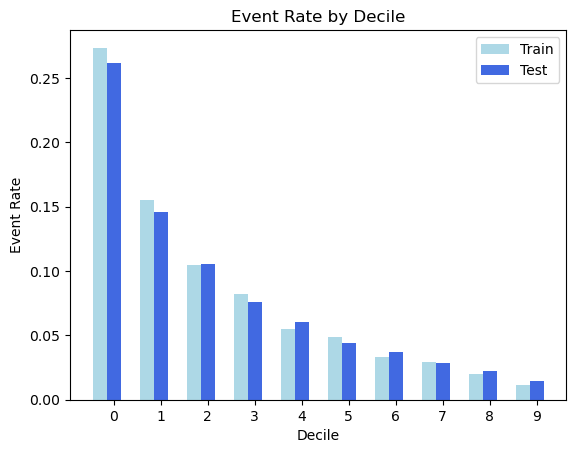

In [15]:
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.legend()
plt.show()